In [488]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import dlc_practical_prologue2 as prologue

print('libraries imported')

libraries imported


To get the data for the first project, we are using one of the functions of *dlc_practical_prologe.py* that randomly generates one for us given a size parameter. It returns a tuple containing the: *training set, targets, classes* and *testing set, targets, classes*. 

In [489]:
sample_size = 1000
sets = prologue.generate_pair_sets(sample_size)

train_set = sets[0]
train_target = sets[1]
train_classes = sets[2]

test_set = sets[3]
test_target = sets[4]
test_classes = sets[5]

The inputs are grayscale MNIST images consisting of two channels ($2 \times 14 \times 14$) representing two different digits. As visualized below, target vector contains the index of the channels which have the highest digit between the two (channel $0$ or $1$). 

Therefore, our task is to maximize the prediction of this boolean value.

For the first training data point with two channels, target is 0


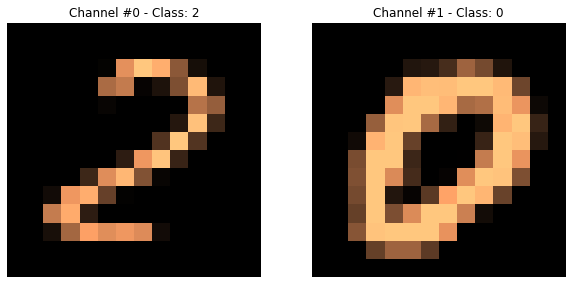

In [490]:
print('For the first training data point with two channels, target is {}'.format(train_target[0]))
fig1, axes = plt.subplots(1, 2, figsize = (10, 7))
ax = axes.ravel()

for i in range(len(ax)):
    ax[i].set_title('Channel #{} - Class: {}'.format(i, train_classes[0][i]))
    ax[i].imshow(train_set[0][i], cmap='copper')
    ax[i].axis('off')
plt.show()

Function to train the model by moving it through the given mini batch size and using Adam as an optimizer.

In [491]:
def train_model(n_epochs, eta, loss_criterion, model, train_input, train_target, mini_batch_size):
    optimizer = torch.optim.Adam(model.parameters())
    for e in range(n_epochs):
        acc_loss = 0 ## set error as 0 each iteration
        ## Using mini-batches
        optimizer.zero_grad()
        for b in range(0, train_input.size(0), mini_batch_size): 
            output = model(train_input.narrow(0, b, mini_batch_size))
            # print('Loss Shapes: Output: {}, Target: {}'.format(output.shape, train_target.narrow(0, b, mini_batch_size).shape))
            loss = loss_criterion(output, train_target.narrow(0, b, mini_batch_size))
            acc_loss = acc_loss + loss.item()

            model.zero_grad() ## setting the gradients to zero before the loss calculation
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                for p in model.parameters():
                    p -= eta * p.grad
                    
    # print('Final Output: ', output, output.shape)
    # print(torch.argmax(output, dim=1))
    print('Model Training Finished - Final loss after {} epochs: {}'.format(n_epochs, acc_loss))

Round the final values outputted from the network into binary values and compare them with the target binary matrix in order to get the number of errors.

In [492]:
def compute_nb_errors(model, input, target):
    with torch.no_grad():
        rounded_to_binary = torch.round(input)
        errors = torch.where(rounded_to_binary != train_target)
    return len(errors[0]) / target.shape[0]

Attempt #1 - Binary Convolutional Network Classifier that takes the number of the hidden layers of the final fully connected layer as a parameter. 

As seen from the results below, it suffers from overfitting at the moment therefore it should be modified (dropout to be added next).

In [498]:
class BinaryCNN(nn.Module):
    def __init__(self, hidden_layer_n): ## defining the layers
        super().__init__()
        self.dropout1 = nn.Dropout2d()
        self.flatten0 = nn.Flatten(0)
        self.flatten1 = nn.Flatten(1)
        
        # Feature Extractors
        self.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1)
        # self.conv3 = nn.Conv2d(128, 128, kernel_size=1, stride=1)
        
        # Classifiers
        self.fc1 = nn.Linear(512, hidden_layer_n)
        self.fc2 = nn.Linear(hidden_layer_n, 1) ## output layers
        
    ## Generally, strides for convolution layers are 1 and for maxpools are 2
    def forward(self, x): 
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size = 2, stride = 2)
        # print('First Conv Layer Shape', x.shape)
        # x = self.dropout1(x)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size = 2, stride = 2)
        # print('Second Conv Layer Shape', x.shape)
        # x = self.dropout1(x)
        # x = F.max_pool2d(F.relu(self.conv3(x)), kernel_size = 2, stride = 2)
        x = self.flatten1(x)
        # print('After Flattening', x.shape)
        x = self.fc1(x)
        # print('First Connected Layer', x.shape)
        # x = self.dropout1(x)

        # x = torch.sigmoid(self.fc2(x))
        x = self.fc2(x)
        x = self.flatten0(x)
        # print('Final Output Shape {} \n'.format(x.shape))
        return x

Benchmarking with different hyperparameters.

In [503]:
hidden_layers = [10, 50, 200, 500, 1000]
model = BinaryCNN(hidden_layer_n=256)
binary_criterion = nn.BCEWithLogitsLoss()
eta = 1e-5
mini_batch_size = 20
nb_epochs = 15


for layer_n in hidden_layers:   
    model = BinaryCNN(hidden_layer_n = layer_n)
    train_model(25, eta, binary_criterion, model, train_set, train_target.to(torch.float32), mini_batch_size)
    
    train_output = torch.sigmoid(model(train_set))
    test_output = torch.sigmoid(model(test_set))
    
    error_train = compute_nb_errors(model, train_output, train_target)
    error_test = compute_nb_errors(model, test_output, test_target)
    
    print('Classification Error on the training set with {} hidden layers: {}%'.format(layer_n, error_train * 100))
    print('Classification Error on the testing set with {} hidden layers: {}%'.format(layer_n, error_test * 100))
    print('')

Model Training Finished - Final loss after 25 epochs: 0.03755403819377534
Classification Error on the training set with 10 hidden layers: 0.0%
Classification Error on the testing set with 10 hidden layers: 48.3%

Model Training Finished - Final loss after 25 epochs: 0.02045655023539439
Classification Error on the training set with 50 hidden layers: 0.0%
Classification Error on the testing set with 50 hidden layers: 50.7%

Model Training Finished - Final loss after 25 epochs: 5.405695426044986
Classification Error on the training set with 200 hidden layers: 3.3000000000000003%
Classification Error on the testing set with 200 hidden layers: 49.6%

Model Training Finished - Final loss after 25 epochs: 2.987766152888071
Classification Error on the training set with 500 hidden layers: 2.1999999999999997%
Classification Error on the testing set with 500 hidden layers: 48.9%

Model Training Finished - Final loss after 25 epochs: 11.493990674614906
Classification Error on the training set with